In [1]:
# Part 2: Handling the Cold start problem with Content-based filtering

# Collaborative filtering relies solely on user-item interactions within the utility matrix. 
# The issue with this approach is that brand new users or items with no interactions get excluded from the recommendation system. 
# This is called the "cold start" problem. 
# Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

# We will generate item-item recommendations using content-based filtering

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Step 2: Load the Data
movies = pd.read_csv("data/ml-latest-small/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Step 3: Data cleaning and Exploration
# We need to clean in 2 ways:
# 1. Genres expressed as a string with a pipe | separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
# 2. Title currently has (year) appended at the end. We will extyract year from each title string and create a new column for it.

# The genres column is currently a string separated with pipes. Let's convert this into a list using the "split" function.

# We want "Adventure|Children|Fantasy" to convert to this: [Adventure, Children, Fantasy].

movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [5]:
# Create a dict containing frequency counts of each genre in our dataset

from collections import Counter

genres_counts = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(genres_counts)} genre labels")
genres_counts

There are 20 genre labels


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [6]:
# we will remove mvoies having no genres listed as its genre label, and also remove from genre_counts dict
movies = movies[movies["genres"] != '(no genres listed)']

del genres_counts['(no genres listed)']

In [7]:
# there is a method 'most_common()' that we can use from the COunter's lib, it will get the genres with highest movie counts
print("The 5 most common genres: \n", genres_counts.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


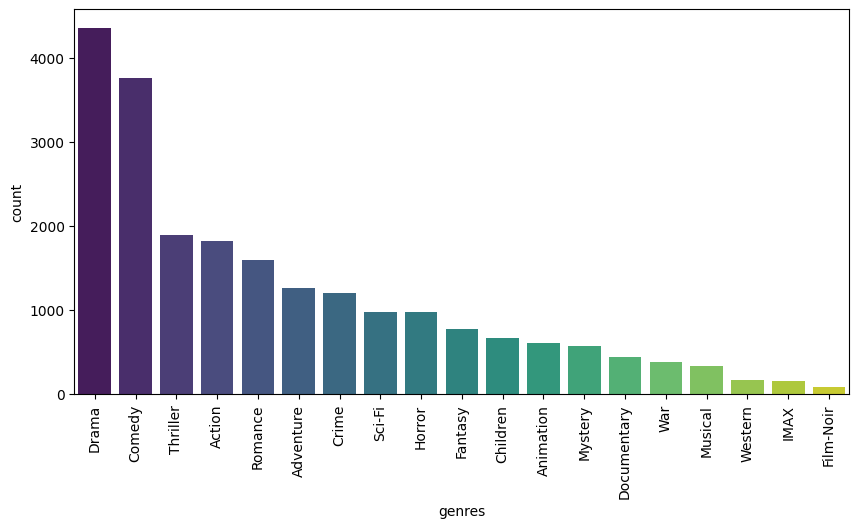

In [8]:
# we will now visualize it.
genres_counts_df = pd.DataFrame([genres_counts]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='viridis')
plt.xticks(rotation=90)
plt.show()

In [11]:
# year of release for movies is in the movie title like 'Toy Story (1995)', so we want to take it out for every entry so we can use it

import re

def extract_year_from_title(title):
    t = title.split(' ')
    year = None
    if re.search(r'\(\d+\)', t[-1]):
        year = t[-1].strip('()')
        year = int(year)
    return year

In [12]:
# test the function I guess
title = "Toy Story (1995)"
year = extract_year_from_title(title)
print(f"Year of release: {year}")
print(type(year))

Year of release: 1995
<class 'int'>


In [14]:
# never seen this before, invokiing apply on a dict into a new field 'year' on the dict
movies['year'] = movies['title'].apply(extract_year_from_title)
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995.0
4,5,Father of the Bride Part II (1995),[Comedy],1995.0


In [15]:
# How many different types of years are covered in the dataset?
movies['year'].nunique()

106

In [18]:
# smart move here, collapsing this into decades to get a general sense of when movies were released

# okay, remove movies with null years
print(f"Original number of movies: {movies['movieId'].nunique()}")

movies = movies[~movies['year'].isnull()]
print(f"Number of movies after removing null years: {movies['movieId'].nunique()}")
# so we trimmed 24 movies off the list

Original number of movies: 9718
Number of movies after removing null years: 9718


In [25]:
x = 1995

def get_decade(year):
    return year - (year%10)

get_decade(x)

1990

In [26]:
movies['decade'] = movies['year'].apply(get_decade)

In [29]:
# Step 4: Transforming the Data
# rows represent movies and columns represent features
# each genre is represented as a separate binary feature. "1" indicates that the movie falls under a given genre, while "0" does not.
genres = list(genres_counts.keys())

for g in genres:
    movies[g] = movies['genres'].transform(lambda x: int(g in x))

# lets see what this looks like:
movies[genres].head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
# wrangle our decade column so that each decade has its own column. 
# We can do this using pandas' get_dummies() function, which works by creating a categorical variable into binary variables.

movie_decades = pd.get_dummies(movies['decade'])
movie_decades.head()

,1900.0,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,False,False,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,True,False,False


In [32]:
# Now, let's create a new movie_features dataframe by combining our genres features and decade features. 
# We can do this using pandas' concat function

movie_features = pd.concat([movies[genres], movie_decades], axis = 1)
movie_features.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,...,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,1,1,1,1,1,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
1,1,0,1,0,1,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
2,0,0,0,1,0,1,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False
3,0,0,0,1,0,1,1,0,0,0,...,False,False,False,False,False,False,False,True,False,False
4,0,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,False


In [33]:
# Step 5: Building a "Similar Movies" Recommender Using Cosine Similarity

from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_features, movie_features)
print(f"Dimensions of our movie features cosine similarity matrix: {cosine_sim.shape}")


Dimensions of our movie features cosine similarity matrix: (9718, 9718)


/Users/kylestanford/Library/CloudStorage/OneDrive-Partners/Documents/GitHub/Recommendation-System/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kylestanford/Library/CloudStorage/OneDrive-Partners/Documents/GitHub/Recommendation-System/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kylestanford/Library/CloudStorage/OneDrive-Partners/Documents/GitHub/Recommendation-System/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [35]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

In [37]:
title = movie_finder('juminiji')
title

'Jumanji (1995)'

In [39]:
# To get relevant recommendations for Jumanji, we need to find its index in the cosine simialrity matrix. 
# To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix.

# Let's create a movie index dictionary called movie_idx where the keys are movie titles and values are movie indices:

movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
idx

1

In [40]:
# using this movie_idx dict, we know jumanji is represented by index 1 in our matrix. Let's get the top 10 most similar movies to Jumanji
n_recommendations = 10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

In [42]:
# similar_movies is an array of indices that represents Jumanji's top 10 recommendations. 
# We can get the corresponding movie titles by either creating an inverse movie_idx mapper or using iloc on the title column of the movies dataframe.

print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
1618    NeverEnding Story II: The Next Chapter, The (1...
8719                   The Cave of the Golden Rose (1991)
9565                            Gulliver's Travels (1996)
1357                                Borrowers, The (1997)
1565                                     Tall Tale (1995)
2539                We're Back! A Dinosaur's Story (1993)
5624    Kirikou and the Sorceress (Kirikou et la sorci...
5975    Asterix & Obelix vs. Caesar (Astérix et Obélix...
Name: title, dtype: object

In [43]:
# package the above logic into a single function.
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Recommendations for {title}:")
    print(movies['title'].iloc[similar_movies])

In [44]:
get_content_based_recommendations('aladin', 5)

Recommendations for Aladdin (1992):
1177                                      Hercules (1997)
95                          Muppet Treasure Island (1996)
673     Land Before Time III: The Time of the Great Gi...
1757                                 Bug's Life, A (1998)
3727                Ferngully: The Last Rainforest (1992)
Name: title, dtype: object
